In [1]:
import os
import re
import time
import copy

from pathlib import Path
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import torchvision
from torchvision import models, datasets, transforms

# import online augmentation libraries
from augmentation_libraries.online_augmentation import augment_image_without_seed

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print(torch.cuda.is_available())

PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118
True


input dir

In [2]:
CURRENT_DIR = os.getcwd()
MAIN_FOLDER = Path(CURRENT_DIR).parent
OUTPUT_FOLDER = os.path.join(MAIN_FOLDER, 'aligned')  
FOLD_DATA = os.path.join(MAIN_FOLDER, 'fold_data') 

BATCH_SIZE = 64

cuda_avail = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda_avail else "cpu")

print(
    f"Current Directory: {CURRENT_DIR}\n",
    f"Main Folder: {MAIN_FOLDER}\n",
    f"Output Folder: {OUTPUT_FOLDER}\n",
    f"Fold Data Folder: {FOLD_DATA}\n",
)

Current Directory: /home/user/CZ4042-SC4001-NND/architecture
 Main Folder: /home/user/CZ4042-SC4001-NND
 Output Folder: /home/user/CZ4042-SC4001-NND/aligned
 Fold Data Folder: /home/user/CZ4042-SC4001-NND/fold_data



Data processing

In [3]:
# Data Transforms
def get_data_transforms():
    normalize = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

    return {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(*normalize)
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(*normalize)
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(*normalize)
        ]),
    }

data_transforms = get_data_transforms()

In [4]:
class BasicImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, augment=False, num_augmentations=2):
        """
        Args:
            image_paths (list): List of image file paths.
            labels (list): List of corresponding labels.
            transform (callable, optional): Transformations to apply to the images.
            augment (bool): Whether to apply online augmentation.
            num_augmentations (int): Number of augmented versions to create per image.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment
        self.num_augmentations = num_augmentations
        
    def __len__(self):
        # Return the actual number of samples after augmentation
        if self.augment:
            return len(self.image_paths) * (self.num_augmentations)
        return len(self.image_paths)
        
    def get_original_len(self):
        """Return the number of original images (without augmentation)"""
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        # Calculate which original image to use
        if self.augment:
            original_idx = idx // self.num_augmentations
        else:
            original_idx = idx
            
        image = Image.open(self.image_paths[original_idx]).convert('RGB')
        label = torch.tensor(self.labels[original_idx], dtype=torch.long)

        if self.augment:
            # When augmenting, first apply augmentation (which already returns a tensor)
            augmented_tensor = augment_image_without_seed(image, final_resolution=(224, 224))
            
            # Skip ToTensor and only apply normalization if needed
            if self.transform:
                # Extract the normalization from transform and apply it directly
                for t in self.transform.transforms:
                    if isinstance(t, transforms.Normalize):
                        augmented_tensor = t(augmented_tensor)
                        
            return augmented_tensor, label

        # For non-augmented images, apply the full transform
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

In [5]:
def load_folds_dataset(image_root, fold_dir, fold_files):
    image_paths = []
    labels = []

    for fold_file in fold_files:
        print(f"Reading fold file: {fold_file}")
        with open(os.path.join(fold_dir, fold_file), 'r') as f:
            next(f)  
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 5:
                    continue
                user_id = parts[0]
                original_img_name = parts[1]
                gender = parts[4].lower()

                if gender not in ["m", "f"]:
                    continue
                label = 0 if gender == "m" else 1

                user_folder = os.path.join(image_root, user_id)
                if not os.path.isdir(user_folder):
                    continue

                for file in os.listdir(user_folder):
                    if original_img_name in file:
                        full_path = os.path.join(user_folder, file)
                        if os.path.isfile(full_path):
                            image_paths.append(full_path)
                            labels.append(label)
                        break

    return image_paths, labels


In [6]:
def get_dataloaders(batch_size, train_folds, val_fold):
    train_image_paths, train_labels = load_folds_dataset(OUTPUT_FOLDER, FOLD_DATA, train_folds)
    val_image_paths, val_labels = load_folds_dataset(OUTPUT_FOLDER, FOLD_DATA, [val_fold])

    train_dataset = BasicImageDataset(train_image_paths, train_labels, transform=data_transforms['train'], augment=True)
    val_dataset = BasicImageDataset(val_image_paths, val_labels, transform=data_transforms['val'], augment=False)

    print(f"Train size: {len(train_dataset)} (from {train_dataset.get_original_len()} original images)")
    print(f"Val size: {len(val_dataset)}")

    if train_dataset.get_original_len() == 0 or len(val_dataset) == 0:
        return None

    num_workers = 16 if cuda_avail else 0
    pin_memory = True if cuda_avail else False
    # Create DataLoader for training and validation datasets
    # Use num_workers and pin_memory only if CUDA is available
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    return {'train': train_loader, 'val': val_loader}

model

In [7]:
class ResnetGender(nn.Module):
    def __init__(self, layers=18, pretrained=True, drop_rate=0.3):
        super().__init__()
        
        if layers == 18:
            base_model = torchvision.models.resnet18(pretrained=pretrained)
            block_expansion = 1
        elif layers == 34:
            base_model = torchvision.models.resnet34(pretrained=pretrained)
            block_expansion = 1
        elif layers == 50:
            base_model = torchvision.models.resnet50(pretrained=pretrained)
            block_expansion = 4

        self.resnet = nn.Sequential(*list(base_model.children())[:-1]) 
        
        self.extra_layer = nn.Sequential(
            nn.Linear(block_expansion * 512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate),
            nn.ReLU(),
        )
        self.gender_predictor = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(drop_rate),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.extra_layer(x)
        return self.gender_predictor(x)


In [8]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

Train

In [9]:
from utils.criss_cross_attention import CrissCrossAttention
# Define the ResNet18 model with Criss-Cross Attention

class ResnetGenderWithCCA(nn.Module):
    def __init__(self, layers=18, pretrained=True, drop_rate=0.3):
        super().__init__()

        assert layers == 18

        # Load and strip down ResNet18
        base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        self.resnet = nn.Sequential(*list(base_model.children())[:-2])  # output before final avgpool (512 x H x W)


        # Add Criss-Cross Attention modules
        self.cc_attn = nn.Sequential(
            CrissCrossAttention(in_dim=512),
            CrissCrossAttention(in_dim=512)
        )

        # Pool and classify
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.extra_layer = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate),
            nn.ReLU()
        )
        self.gender_predictor = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(drop_rate),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.resnet(x)         # Backbone
        x = self.cc_attn(x)        # CCA attention
        x = self.avgpool(x)        # Global pooling
        x = torch.flatten(x, 1)
        x = self.extra_layer(x)    # FC layer (same as ResnetGender)
        return self.gender_predictor(x)


def load_model(drop_rate=0.3, use_cca=True, pretrained=True):
    if use_cca:
        model = ResnetGenderWithCCA(pretrained=pretrained, drop_rate=drop_rate)
    else:
        model = ResnetGender(layers=18, pretrained=pretrained, drop_rate=drop_rate)
    return model.to(DEVICE)

In [10]:
def train_model(model, dataloaders, optimizer, num_epochs=50, patience=10):
    criterion = LabelSmoothingCrossEntropy()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    epochs_no_improve = 0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_prec': [], 'val_prec': [],
        'train_rec': [], 'val_rec': [],
        'train_f1': [], 'val_f1': [],
    }
    
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            all_preds, all_labels = [], []

            for inputs, labels in dataloaders[phase]:
                # Start the minibatch timer
                minibatch_start_time = time.time()
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                # End the minibatch timer
                minibatch_time = time.time() - minibatch_start_time

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_prec = precision_score(all_labels, all_preds, zero_division=0)
            epoch_rec = recall_score(all_labels, all_preds, zero_division=0)
            epoch_f1 = f1_score(all_labels, all_preds, zero_division=0)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f"{phase.upper()} — Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | "
                  f"Prec: {epoch_prec:.4f} | Rec: {epoch_rec:.4f} | F1: {epoch_f1:.4f}")

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
        if phase == 'train':
            scheduler.step()
            
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds.")

    def plot_training_curves(history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy over Epochs")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history['val_loss'], label='Validation Loss', color='orange')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Validation Loss over Epochs")
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_training_curves(history)
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete — Best Val Loss: {best_loss:.4f}")
    return model, history


Fold 0: Val = fold_0_data.txt, Train = ['fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_0_data.txt
Train size: 26994 (from 13497 original images)
Val size: 3995

Epoch 1/50
TRAIN — Loss: 0.5731 | Acc: 0.7437 | Prec: 0.7541 | Rec: 0.7925 | F1: 0.7728
VAL — Loss: 0.6775 | Acc: 0.6788 | Prec: 0.6183 | Rec: 0.8922 | F1: 0.7304
Epoch 1 completed in 24.65 seconds.

Epoch 2/50
TRAIN — Loss: 0.5203 | Acc: 0.7936 | Prec: 0.8008 | Rec: 0.8318 | F1: 0.8160
VAL — Loss: 0.6199 | Acc: 0.7204 | Prec: 0.7883 | Rec: 0.5832 | F1: 0.6704
Epoch 2 completed in 46.69 seconds.

Epoch 3/50
TRAIN — Loss: 0.5010 | Acc: 0.8062 | Prec: 0.8124 | Rec: 0.8421 | F1: 0.8270
VAL — Loss: 0.5663 | Acc: 0.7695 | Prec: 0.7662 | Rec: 0.7587 | F1: 0.7624
Epoch 3 completed in 66.29 seconds.

Epoch 4/50
TRAIN — Loss: 0.4828 | Acc: 0.8193 

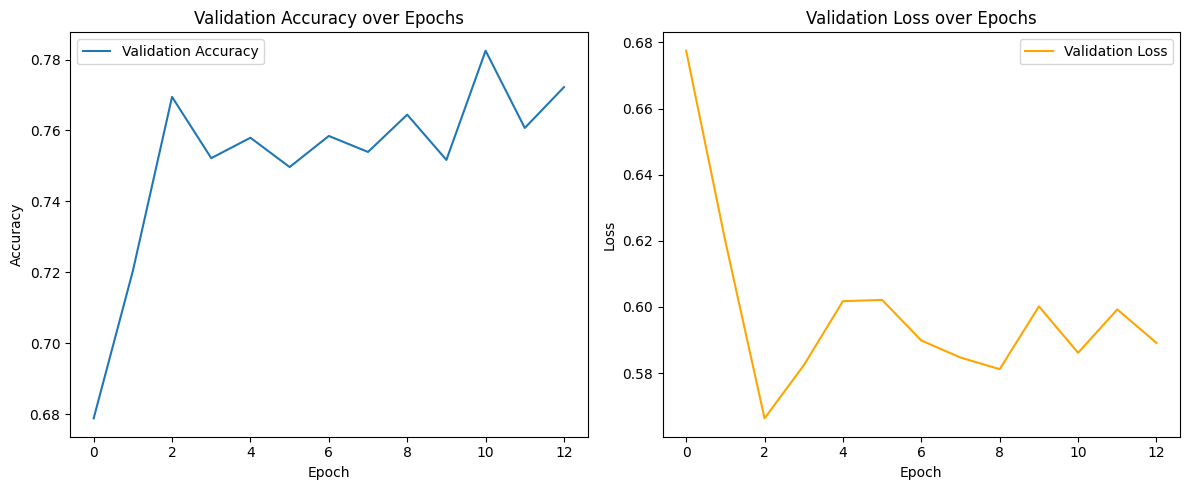


Training complete — Best Val Loss: 0.5663
Fold 1: Val = fold_1_data.txt, Train = ['fold_0_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_1_data.txt
Train size: 27766 (from 13883 original images)
Val size: 3609

Epoch 1/50
TRAIN — Loss: 0.5724 | Acc: 0.7441 | Prec: 0.7477 | Rec: 0.7821 | F1: 0.7645
VAL — Loss: 0.5873 | Acc: 0.7312 | Prec: 0.7450 | Rec: 0.7823 | F1: 0.7632
Epoch 1 completed in 22.87 seconds.

Epoch 2/50
TRAIN — Loss: 0.5218 | Acc: 0.7901 | Prec: 0.7908 | Rec: 0.8226 | F1: 0.8063
VAL — Loss: 0.5758 | Acc: 0.7412 | Prec: 0.8037 | Rec: 0.7047 | F1: 0.7509
Epoch 2 completed in 42.70 seconds.

Epoch 3/50
TRAIN — Loss: 0.4997 | Acc: 0.8066 | Prec: 0.8064 | Rec: 0.8369 | F1: 0.8213
VAL — Loss: 0.6040 | Acc: 0.7257 | Prec: 0.7077 | Rec: 0.8594 | F1: 0.7762
Epoch 3 completed in 61.99 seconds.

Epo

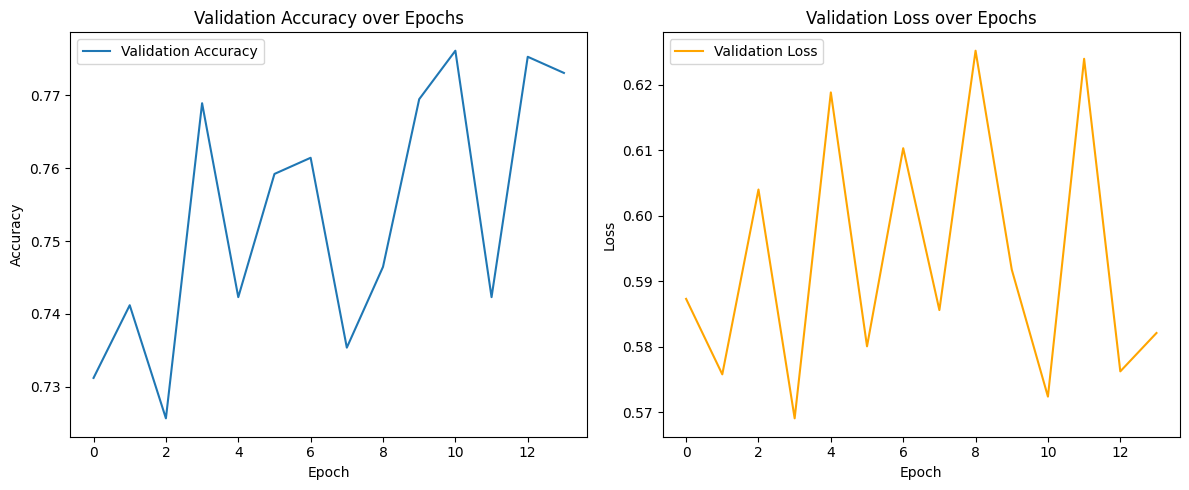


Training complete — Best Val Loss: 0.5691
Fold 2: Val = fold_2_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_2_data.txt
Train size: 28710 (from 14355 original images)
Val size: 3137

Epoch 1/50
TRAIN — Loss: 0.5852 | Acc: 0.7308 | Prec: 0.7381 | Rec: 0.7617 | F1: 0.7497
VAL — Loss: 0.6069 | Acc: 0.7042 | Prec: 0.7874 | Rec: 0.6533 | F1: 0.7141
Epoch 1 completed in 20.03 seconds.

Epoch 2/50
TRAIN — Loss: 0.5319 | Acc: 0.7833 | Prec: 0.7874 | Rec: 0.8091 | F1: 0.7981
VAL — Loss: 0.5494 | Acc: 0.7721 | Prec: 0.7818 | Rec: 0.8281 | F1: 0.8043
Epoch 2 completed in 39.77 seconds.

Epoch 3/50
TRAIN — Loss: 0.5133 | Acc: 0.7983 | Prec: 0.8039 | Rec: 0.8186 | F1: 0.8112
VAL — Loss: 0.6223 | Acc: 0.7074 | Prec: 0.8526 | Rec: 0.5834 | F1: 0.6928
Epoch 3 completed in 60.26 seconds.

Epo

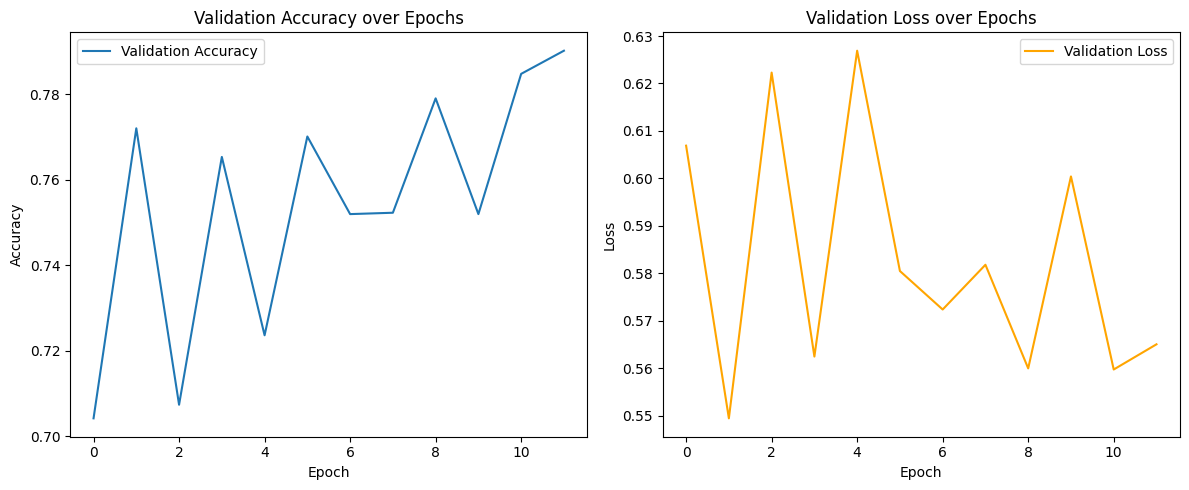


Training complete — Best Val Loss: 0.5494
Fold 3: Val = fold_3_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_3_data.txt
Train size: 28372 (from 14186 original images)
Val size: 3306

Epoch 1/50
TRAIN — Loss: 0.5817 | Acc: 0.7370 | Prec: 0.7459 | Rec: 0.7690 | F1: 0.7573
VAL — Loss: 0.5589 | Acc: 0.7604 | Prec: 0.7380 | Rec: 0.8697 | F1: 0.7985
Epoch 1 completed in 20.48 seconds.

Epoch 2/50
TRAIN — Loss: 0.5228 | Acc: 0.7912 | Prec: 0.7980 | Rec: 0.8149 | F1: 0.8064
VAL — Loss: 0.5626 | Acc: 0.7562 | Prec: 0.8065 | Rec: 0.7278 | F1: 0.7652
Epoch 2 completed in 40.36 seconds.

Epoch 3/50
TRAIN — Loss: 0.5039 | Acc: 0.8017 | Prec: 0.8092 | Rec: 0.8221 | F1: 0.8156
VAL — Loss: 0.5566 | Acc: 0.7698 | Prec: 0.8055 | Rec: 0.7622 | F1: 0.7833
Epoch 3 completed in 60.75 seconds.

Epo

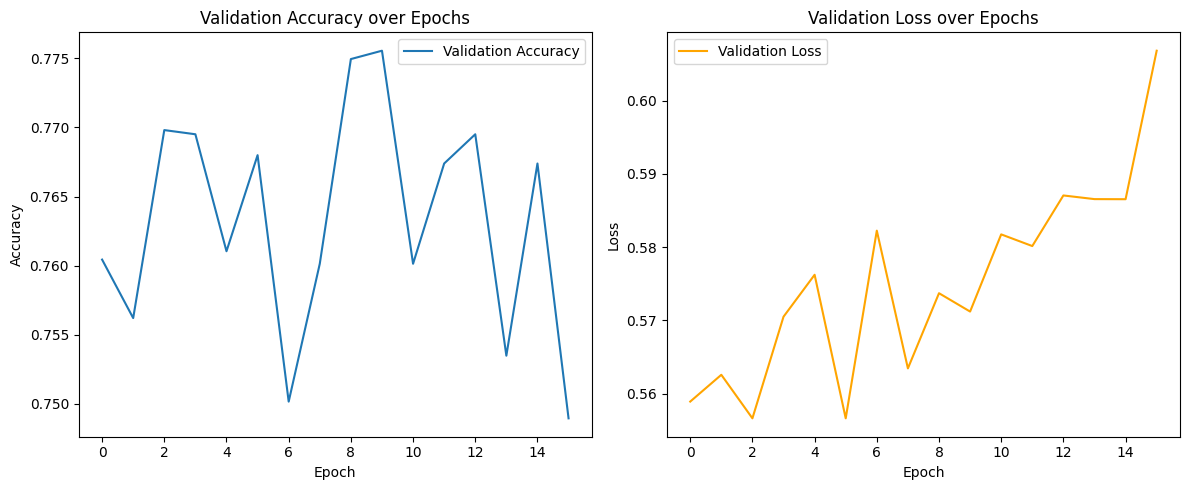


Training complete — Best Val Loss: 0.5566
Fold 4: Val = fold_4_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Train size: 28094 (from 14047 original images)
Val size: 3445

Epoch 1/50
TRAIN — Loss: 0.5634 | Acc: 0.7530 | Prec: 0.7576 | Rec: 0.7923 | F1: 0.7746
VAL — Loss: 0.6233 | Acc: 0.7086 | Prec: 0.7371 | Rec: 0.7100 | F1: 0.7233
Epoch 1 completed in 19.88 seconds.

Epoch 2/50
TRAIN — Loss: 0.5109 | Acc: 0.8011 | Prec: 0.8022 | Rec: 0.8343 | F1: 0.8180
VAL — Loss: 0.5955 | Acc: 0.7213 | Prec: 0.7768 | Rec: 0.6742 | F1: 0.7219
Epoch 2 completed in 39.96 seconds.

Epoch 3/50
TRAIN — Loss: 0.4929 | Acc: 0.8136 | Prec: 0.8128 | Rec: 0.8472 | F1: 0.8296
VAL — Loss: 0.6201 | Acc: 0.7321 | Prec: 0.7812 | Rec: 0.6953 | F1: 0.7358
Epoch 3 completed in 60.62 seconds.

Epo

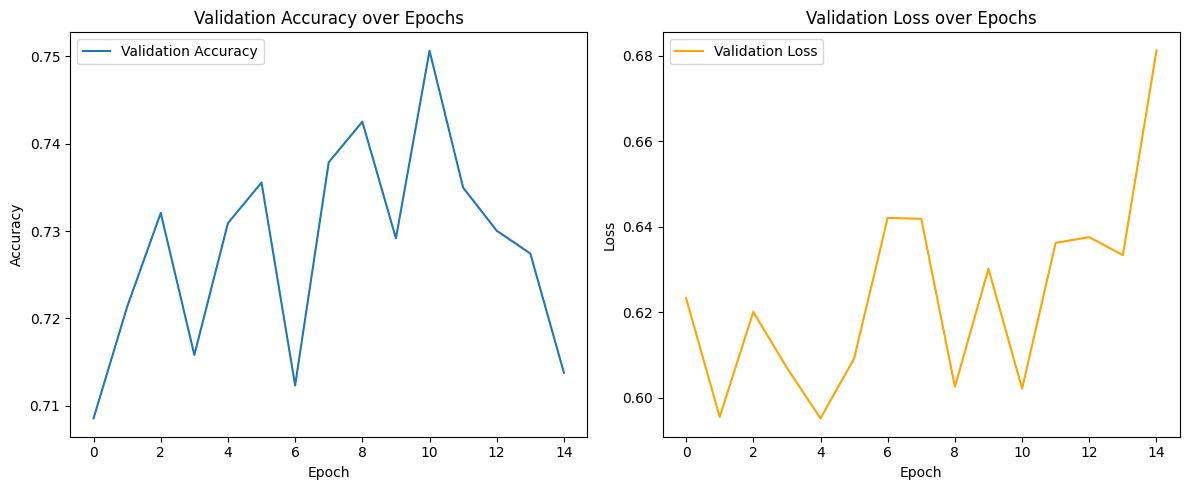


Training complete — Best Val Loss: 0.5952


In [11]:
all_folds = [f"fold_{i}_data.txt" for i in range(5)]
for fold_idx in range(5):
    val_fold = all_folds[fold_idx]
    train_folds = [f for i, f in enumerate(all_folds) if i != fold_idx]
    print(f"Fold {fold_idx}: Val = {val_fold}, Train = {train_folds}")

    dataloaders = get_dataloaders(batch_size=64, train_folds=train_folds, val_fold=val_fold)

    model = load_model(drop_rate=0.3)
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=0.0005)

    model, history = train_model(model, dataloaders, optimizer, num_epochs=50)
    best_val_acc = max(history['val_acc'])

In [12]:
# Save the model
torch.save(model, 'resnet50_cca_model.pth')
# Save the training history
torch.save(history, 'training_history.pth')

: 